<a href="https://colab.research.google.com/github/yajuna/tensorflow_pde/blob/master/navier_stokes_PINN_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This work is based on the methodology originally developed by [Raissi](https://github.com/maziarraissi/PINNs/blob/master/main/continuous_time_identification%20(Navier-Stokes)/NavierStokes.py), and the Tensorflow 2.0 modification by [Blechschmidt](https://github.com/janblechschmidt/PDEsByNNs).

A Tensorflow 2.0 implementation of the inference problem for the Navier Stokes equation is [here](https://github.com/yajuna/tensorflow_pde/blob/master/navier_stokes_PINN_Solver.ipynb). This notebook is a Tensorflow 2.0 implementation of the Navier Stokes identification problem. We run this notebook with the original data provided by the author to test our implementation for the inference problem. This code is modified from [the heat identification code](https://github.com/yajuna/tensorflow_pde/blob/master/Heat_equation_with_tensorflow.ipynb)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas

from time import time

from IPython.display import clear_output

clear_output()

In [2]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

pi = tf.constant(np.pi, dtype=DTYPE)

# Define initial condition
def fun_0(x, y):
    psi = -tf.sin(2 * x)
    p = tf.sin(3. * y)
    # return [psi, p]
    return tf.concat([psi, p], axis=1)

# Define boundary condition-- for y = -8 <--------------------------- ask
def fun_lx(t, x):
    psi = -tf.sin(2 * x)
    p = tf.sin(3. * t)
    return tf.concat([psi, p], axis=1)

# Define boundary condition-- for x = -15 <--------------------------- ask
def fun_ly(t, y):
    psi = -tf.sin(2 * t)
    p = tf.sin(3. * y)
    return tf.concat([psi, p], axis=1)
# Define boundary condition-- for y = 8 <--------------------------- ask
def fun_ux(t, x):
    psi = -tf.sin(2 * x)
    p = tf.sin(3. * t)
    return tf.concat([psi, p], axis=1)

# Define boundary condition-- for x = 25 <--------------------------- ask
def fun_uy(t, y):
    psi = -tf.sin(2 * t)
    p = tf.sin(3. * y)
    return tf.concat([psi, p], axis=1)

# Residual of the PDE is defined in fun_r
# all variables: t,x,u, u_t, u_x, u_y, u_xx, u_yy, v, v_t, v_x, v_y, v_xx, v_yy, p, p_x, p_y
def fun_r(u, u_t, u_x, u_y, u_xx, u_yy, v, v_t, v_x, v_y, v_xx, v_yy, p_x, p_y):
  f = u_t + lambda_1 * (u * u_x + v * u_y) + p_x - lambda_2 * (u_xx + u_yy)
  g = v_t + lambda_1 * (u * v_x + v * v_y) + p_y - lambda_2 * (v_xx + v_yy)
  return tf.concat([f, g], axis=1)

In [3]:
# Set number of data points
N_0 = 200
N_b = 200
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -15.
xmax = 25.
ymin = -8.
ymax = 8.

# Lower bounds
lb = tf.constant([tmin, xmin, ymin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax, ymax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
y_0 = tf.random.uniform((N_0,1), lb[2], ub[2], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0, y_0], axis=1)

# Boundary data points
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_lb = tf.ones((N_b,1), dtype=DTYPE)*lb[1]
x_ub = tf.ones((N_b,1), dtype=DTYPE)*ub[1]
y_lb = tf.ones((N_b,1), dtype=DTYPE)*lb[2]
y_ub = tf.ones((N_b,1), dtype=DTYPE)*ub[2]

X_lb = tf.concat([t_b, x_lb, y_0], axis=1)
X_ub = tf.concat([t_b, x_ub, y_0], axis=1)
Y_lb = tf.concat([t_b, x_0, y_lb], axis=1)
Y_ub = tf.concat([t_b, x_0, y_ub], axis=1)

# Evaluate initial condition at x_0
pp_0 = fun_0(x_0, y_0)

# Evaluate boundary condition at (t_b, x_b, y_b) <---------- to fix
pp_lx = fun_lx(t_b, x_lb)
pp_ly = fun_ly(t_b, y_lb)
pp_ux = fun_lx(t_b, x_ub)
pp_uy = fun_ly(t_b, y_ub)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
y_r = tf.random.uniform((N_r,1), lb[2], ub[2], dtype=DTYPE)
X_r = tf.concat([t_r, x_r, y_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_lb, X_ub, Y_lb, Y_ub]
pp_data = [pp_0, pp_lx, pp_ux, pp_ly, pp_uy]

In [4]:
# Define model architecture

class PINN_NeuralNet(tf.keras.Model):
  """Basic architecture of the PINN model
  """

  def __init__(self, lb, ub,
               output_dim = 1,
               num_hidden_layers = 8,
               num_neurons_per_layer = 20,
               activation = 'tanh',
               kernel_initializer = 'glorot_normal',
               **kwargs):
    super().__init__(**kwargs)

    self.num_hidden_layers = num_hidden_layers
    self.output_dim = output_dim
    self.lb = lb
    self.ub = ub

    # Define NN architecture
    self.scale = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                             activation=tf.keras.activations.get(activation),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.num_hidden_layers)]
    self.out = tf.keras.layers.Dense(output_dim)

  def call(self, X):
    """
    Forward-pass thru NN
    """
    Z = self.scale(X)
    for i in range(self.num_hidden_layers):
      Z = self.hidden[i](Z)
    return self.out(Z)

In [5]:
class PINNIdentificationNet(PINN_NeuralNet):
    def __init__(self, *args, **kwargs):

        # Call init of base class
        super().__init__(*args,**kwargs)

        # Initialize variable for lambda
        # initial guess: lambd1 = 0.16 / (720 * 1300), lambd2 = 1.0 / (720 * 1300)
        # use value after 6400 steps of training
        # It 06400: loss = 7.85567093e+00 lambda1 = 6.51998147e-02 lambda2 = -1.95997432e-36
        self.lambd1 = tf.Variable(1.0, trainable=True, dtype=DTYPE)
        self.lambd1_list = []

        self.lambd2 = tf.Variable(1.0, trainable=True, dtype=DTYPE)
        self.lambd2_list = []

## Major modification in PINNSolver- Change dimensions of input and output variables

### to do
- see how boundary conditions are defined;

- see where to use the data file

- run on HYAK

In [6]:
class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model

        # Store collocation points, separate t and x
        self.t = X_r[:,0:1]
        self.x = X_r[:,1:2]
        self.y = X_r[:,2:3]

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0

    def get_r(self):

        with tf.GradientTape(persistent=True) as tape:
            # Watch variables representing t and x during this GradientTape
            tape.watch(self.t)
            tape.watch(self.x)
            tape.watch(self.y)

            # Determine residual
            pp = self.model(tf.stack([self.t[:,0], self.x[:,0], self.y[:,0]], axis=1))
            psi = pp[:, 0:1]
            p = pp[:,1:2]

            # Compute gradients
            u = tape.gradient(psi, self.y)
            v = -tape.gradient(psi, self.x)

            u_x = tape.gradient(u, self.x)
            u_y = tape.gradient(u, self.y)

            v_x = tape.gradient(v, self.x)
            v_y = tape.gradient(v, self.y)



        p_x = tape.gradient(p, self.x)
        p_y = tape.gradient(p, self.y)

        u_t = tape.gradient(u, self.t)
        u_xx = tape.gradient(u_x, self.x)
        u_yy = tape.gradient(u_y, self.y)

        v_t = tape.gradient(v, self.t)
        v_xx = tape.gradient(v_x, self.x)
        v_yy = tape.gradient(v_y, self.y)

        del tape

        return self.fun_r(u, u_t, u_x, u_y, u_xx, u_yy, v, v_t, v_x, v_y, v_xx, v_yy, p_x, p_y) ########


    def loss_fn(self, X_r, X_data, pp_data):

        # Compute phi_r
        r = self.get_r()
        phi_r = tf.reduce_mean(tf.square(r))

        # Initialize loss
        loss = phi_r

        # Add phi_0 and phi_b to the loss
        for i in range(len(X_data)):
            pp_pred = self.model(X_data[i])
            loss += tf.reduce_mean(tf.square(pp_data[i] - pp_pred))

        return loss



    def get_grad(self, X_r, X_data, pp_data):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn(X_r, X_data, pp_data)

        g = tape.gradient(loss, self.model.trainable_variables)
        del tape

        return loss, g


    def fun_r(self, u, u_t, u_x, u_y, u_xx, u_yy, v, v_t, v_x, v_y, v_xx, v_yy, p_x, p_y):
        """Residual of the PDE"""
        f = u_t + self.model.lambd1 * (u * u_x + v * u_y) + p_x - self.model.lambd2 * (u_xx + u_yy)
        g = v_t + self.model.lambd1 * (u * v_x + v * v_y) + p_y - self.model.lambd2 * (v_xx + v_yy)
        return tf.concat([f, g], axis=1)

    def solve_with_TFoptimizer(self, optimizer, X, pp, N=1001):
        """This method performs a gradient descent type optimization."""

        @tf.function
        def train_step():
            loss, grad_theta = self.get_grad(X_r, X, pp)

            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            return loss

        for i in range(N):

            loss = train_step()

            self.current_loss = loss.numpy()
            self.callback()

    def callback(self, xr=None):
        lambd1 = self.model.lambd1.numpy()
        self.model.lambd1_list.append(lambd1)

        lambd2 = self.model.lambd2.numpy()
        self.model.lambd2_list.append(lambd2)

        if self.iter % 100 == 0:
            print('It {:05d}: loss = {:10.8e} lambda1 = {:10.8e} lambda2 = {:10.8e}'.format(self.iter, self.current_loss, lambd1, lambd2))

        self.hist.append(self.current_loss)
        self.iter += 1


    # def plot_solution(self, **kwargs):
    #     N = 411
    #     tspace = np.linspace(self.model.lb[0], self.model.ub[0], N)
    #     xspace = np.linspace(self.model.lb[1], self.model.ub[1], N)
    #     yspace = np.linspace(self.model.lb[2], self.model.ub[2], N)
    #     T, X, Y = np.meshgrid(tspace, xspace, yspace)
    #     Xgrid = np.vstack([T.flatten(),X.flatten(),Y.flatten()]).T
    #     upred = self.model(tf.cast(Xgrid,DTYPE))
    #     U = upred.numpy().reshape(N,N)
    #     fig = plt.figure(figsize=(9,6))
    #     ax = fig.add_subplot(111, projection='3d')
    #     ax.plot_surface(T, X, Y, U, cmap='viridis', **kwargs)
    #     ax.set_xlabel('$t$')
    #     ax.set_ylabel('$x$')
    #     ax.set_zlabel('$u_\\theta(t,x)$')
    #     ax.view_init(35,35)
    #     return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

    def plot_loss_and_param(self, axs=None):
        if axs:
            ax1, ax2 = axs
            self.plot_loss_history(ax1)
        else:
            ax1 = self.plot_loss_history()
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        # color = 'tab:blue'
        ax2.tick_params(axis='y', labelcolor='tab:blue')
        ax2.plot(range(len(self.hist)), self.model.lambd1_list,'-',color='tab:blue')
        ax2.plot(range(len(self.hist)), self.model.lambd2_list,'-',color='tab:red')
        ax2.set_ylabel('$\\lambda^{n_{epoch}}$', color='tab:blue')
        return (ax1,ax2)

In [7]:
# initialize model
model = PINNIdentificationNet(lb, ub, num_hidden_layers=2)
model.build(input_shape=(None,3))

# initialize PINN solver
solver = PINNSolver(model, X_r)

In [12]:
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

# start timer
t0 = time()

solver.solve_with_TFoptimizer(optim, X_data, pp_data, N=6001)

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 06100: loss = 1.97757101e+00 lambda1 = 3.58670242e-02 lambda2 = 1.92869343e-02
It 06200: loss = 1.97645152e+00 lambda1 = 6.64312020e-02 lambda2 = 1.66938156e-02
It 06300: loss = 1.97584069e+00 lambda1 = 6.23601601e-02 lambda2 = 1.86747611e-02
It 06400: loss = 1.97518408e+00 lambda1 = 5.79190701e-02 lambda2 = 2.21205447e-02
It 06500: loss = 1.97445965e+00 lambda1 = 5.32725416e-02 lambda2 = 2.58298442e-02
It 06600: loss = 1.97367895e+00 lambda1 = 4.96826284e-02 lambda2 = 2.88453493e-02
It 06700: loss = 1.97285128e+00 lambda1 = 4.81650308e-02 lambda2 = 3.07787042e-02
It 06800: loss = 1.97197640e+00 lambda1 = 4.85227779e-02 lambda2 = 3.16888839e-02
It 06900: loss = 1.97104633e+00 lambda1 = 4.97267805e-02 lambda2 = 3.18039805e-02
It 07000: loss = 1.97004819e+00 lambda1 = 5.05036227e-02 lambda2 = 3.13373841e-02
It 07100: loss = 1.96992183e+00 lambda1 = 5.05153537e-02 lambda2 = 3.12557891e-02
It 07200: loss = 1.96980572e+00 lambda1 = 5.05098477e-02 lambda2 = 3.11706215e-02
It 07300: loss =

In [ ]:
# solver.plot_solution();

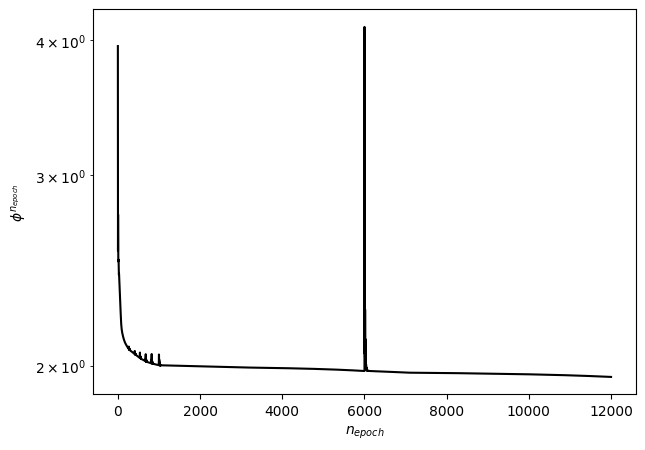

In [13]:
solver.plot_loss_history();

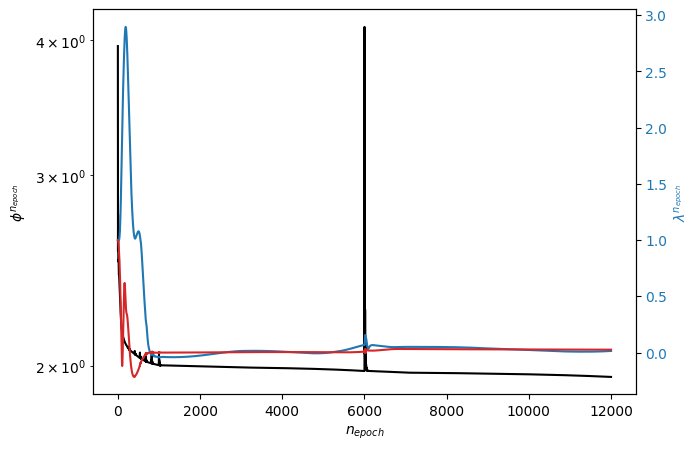

In [14]:
solver.plot_loss_and_param();